In [4]:
import numpy as np
import math

import matplotlib.pylab as plt
%matplotlib inline


from copy import deepcopy
from sklearn.metrics import r2_score

In [30]:
# path_to_data = 'Data/Stocks/xrx.us.txt'
path_to_data = 'Data/Stocks/qgen.us.txt'

with open(path_to_data, 'r') as stream:
    data_lines = stream.readlines()

data = list()

data_lines = data_lines[1:]

for line in data_lines:
    try:
        data.append(float(line.split(',')[1]))
    except:
        print(line)

data = np.array(data)

In [64]:
class ARMA_OGD:
    """
    AutoRegressive Moving Average model with parameter estimation by Online Gradient Descent.
    """
    
    def __init__(self, k = 3, q = 3, eta = 0.00001, threshold = 0.00001, logger=False, plot=False):
        self.k = k
        self.q = q
        self.eta = eta
        self.threshold = threshold
        self.w_ma = np.random.randn(k)
        self.w_ar = np.random.randn(q)
        
        self.logger = logger
        self.plot = plot
        
    def fit(self, X, n_epochs = 100):
        max_kq = max(self.k, self.q)
        k_offset = max_kq - self.k
        q_offset = max_kq - self.q
        
        w_ma = self.w_ma
        w_ar = self.w_ar
        
        
        n = X.shape[0]
        
        Y = np.random.randn(n)
        
        ma_changes = list()
        ar_changes = list()
        errors = list()
        
        count = 0
        
        for i in range(n_epochs):
            old_ma = w_ma.copy()
            old_ar = w_ar.copy()
            
            for j in np.random.permutation(n - max_kq):
                count += 1
                
                curr_idx = j + max_kq
                
                x_prev = X[j+k_offset : curr_idx]
                y_prev = Y[j+q_offset : curr_idx]
                
                pred = np.dot(x_prev, w_ma) + np.dot(y_prev, w_ar)
                
                Y[curr_idx] = pred
                err = X[curr_idx] - pred
                
                w_ma += err * x_prev * self.eta 
                w_ar += err * y_prev * self.eta
                
            ma_change = np.linalg.norm(old_ma - w_ma)
            ma_changes.append(ma_change)
            
            ar_change = np.linalg.norm(old_ar - w_ar)
            ar_changes.append(ar_change)
            
            mean_abs_error = np.mean(np.abs(Y[max_kq:] - X[max_kq:]))
            errors.append(mean_abs_error)
                       
            
            if ar_change < self.threshold and ma_change < self.threshold:
                break
     
        self.w_ma = w_ma
        self.w_ar = w_ar
    
    def predict(self, X):
        max_kq = max(self.k, self.q)
        
        n = X.shape[0]
        Y = np.zeros(n)
        
        for i in np.arange(n - max_kq):
            curr_idx = i + max_kq
            
            x_prev = X[i + max_kq - self.k : curr_idx]
            y_prev = Y[i + max_kq - self.q : curr_idx]
            
            Y[curr_idx] = np.dot(x_prev, self.w_ma) + np.dot(y_prev, self.w_ar)
            
        
        return Y

In [ ]:
test_len = 100

def driver_arma_ogd(epoch):
    for epoch in range(30, 200, 20):
        model.fit(X[:len(X) - test_len], n_epochs=epoch)
        pred_vals = model.predict(X[len(X) - test_len:])
        actual_vals = X[len(X) - test_len:]
        print(epoch, " : ", r2_score(pred_vals[3:], actual_vals[3:]))

In [ ]:
plt.plot([x for x in range(test_len)], actual_vals)
        
plt.plot([x for x in range(test_len)], pred_vals)

In [ ]:
r2_score(pred_vals[3:], actual_vals[3:])

In [31]:
import numpy as np
from numpy.linalg import inv
from scipy.optimize import fmin_bfgs
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.arima_process import arma_generate_sample


class ARMA_ONS:
    
    def __init__(self, m, k, q):
        self.m = m
        self.k = k
        self.q = q
        self.L = None
    
    def fit(self, X):
        """
        args:
            X: train data
        """
        m = self.m
        k = self.k
        q = self.q
        
        D = np.sqrt(2*(m+k))
        G = 2*np.sqrt(m+k)*D

    #     rate = 0.5*min(1./(m+k), 4*G*D)
        rate = 0.00001
        epsilon = 1./(rate**2 * D**2)

        A = np.diag([1]*(m+k)) * epsilon
        A = np.matrix(A)

        T = len(X)

        L = np.random.uniform(-0.5, 0.5, (m+k, 1))
        L = np.matrix(L)

        X_p = np.zeros(T)
        loss = np.zeros(T)
        
        for t in range(T):
            #predict
            X_t = 0
            
            for i in range(m+k):
                if t-i-1 < 0:
                    break
                X_t += L[i]*X[t-i-1]
            X_p[t] = X_t

            #loss
            loss[t] = (X[t]-X_t)**2

            #update
            nabla = np.zeros((m+k, 1))
            
            for i in range(m+k):
                x = X[t-i-1] if t-i-1 >= 0 else 0
                nabla[i, 0] = -2*(X[t]-X_t)*x
            
            A = A + np.dot(nabla, nabla.T)
            L = L - 1/rate*np.dot(inv(A), nabla)
        
        self.L = L
        self.X_p = X_p
        
        return X_p, loss


    def predict(self, X):
        """
        args:
            L: trained list
            X: test data
        """
        L = self.L
        m = self.m
        k = self.k
        
        T = len(X)
        offset_original = len(self.X_p)
        X_p = np.concatenate((self.X_p, np.zeros(T)))
        
        
        for t in range(offset_original, offset_original+T):
            X_t = 0
            
            for i in range(m+k):
                
                if t-i-1 < 0:
                    break
                
                X_t += L[i]*X[t-offset_original-i-1]
            
            X_p[t] = X_t
        
        return X_p[offset_original:]


In [32]:
train_test_split = 0.8

m = 3
k = 2
q = 2

test_start_val = int(math.ceil(len(data) * train_test_split))

train_data = data[:test_start_val]
test_data = data[test_start_val:]

In [33]:
arma_ons = ARMA_ONS(m, k, q)

_, loss = arma_ons.fit(train_data)

y_hats = arma_ons.predict(test_data)

print (len(y_hats),len(test_data))

print(r2_score(y_hats[m:], test_data[m:]))

640 640
0.960091732568


In [101]:
def plot_accuracy_graphs(pred_vals, actual_vals, filename_to_save='temp.png'):
    plt.plot([x for x in range(len(actual_vals))], actual_vals, label='True value')
        
    plt.plot([x for x in range(len(pred_vals))], pred_vals, label='Predicted value')
    
    plt.xlabel('Index of data point')
    plt.ylabel('Stock value')
    
    plt.legend(loc = 'upper left')
    
    plt.savefig(filename_to_save)
    plt.show()

In [35]:
def loss_graph(pred_vals,actual_vals):
    x_vals = list()
    
    y_vals = list()
    
    for val_iter in range(len(actual_vals)):
        x_vals.append(val_iter)
        
        y_vals.append((actual_vals[val_iter] - pred_vals[val_iter]) ** 2)
        
    plt.plot(x_vals, y_vals)
    plt.show()

In [41]:
import math
import numpy as np


def Huber(yHat, y, delta=1.):
    return np.where(np.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(np.abs(y-yHat)-0.5*delta))

def L1(yHat, y):
    return np.sum(np.absolute(yHat - y))

def MSE(yHat, y):
    return np.sum((yHat - y)**2) / y.size

## LSTM

In [104]:
import pandas as pd

df = pd.read_csv('Sharath_Data/nyc_taxi_FF0.915ORELM23_pred.csv')

actual_val = np.array(list(df['data']))
pred_val = np.array(list(df['prediction-1step']))

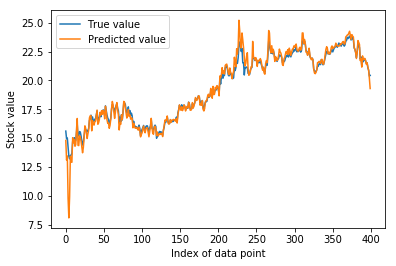

In [109]:
plot_accuracy_graphs(pred_val[-400:], actual_val[-400:], 'ORELM_accuracy.png')

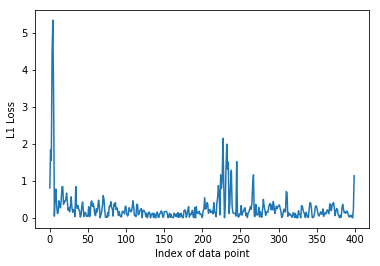

In [106]:
l1_loss_orelm = list()

for val_iter in range(len(actual_val)):
    l1_loss_orelm.append(L1(pred_val[val_iter], actual_val[val_iter]))

t = 400
plt.plot([x for x in range(400)], l1_loss_orelm[-400:])

plt.ylabel('L1 Loss')
plt.xlabel('Index of data point')

plt.savefig('L1_loss_orelm.png')

plt.show()

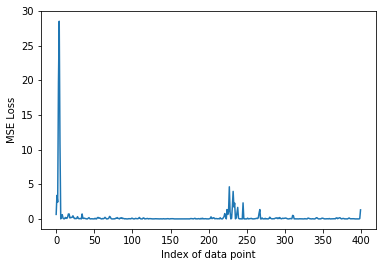

In [107]:
mse_loss_lstm = list()

for val_iter in range(len(actual_val)):
    mse_loss_lstm.append(MSE(pred_val[val_iter], actual_val[val_iter]))

t = 400

plt.plot([x for x in range(400)], mse_loss_lstm[-400:])

plt.ylabel('MSE Loss')
plt.xlabel('Index of data point')

plt.savefig('MSE_loss_orelm.png')

plt.show()

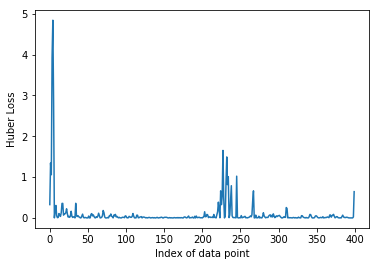

In [108]:
huber_loss_lstm = list()

for val_iter in range(len(actual_val)):
    huber_loss_lstm.append(Huber(pred_val[val_iter], actual_val[val_iter]))

t = 400
plt.plot([x for x in range(400)], huber_loss_lstm[-400:])

plt.ylabel('Huber Loss')
plt.xlabel('Index of data point')

plt.savefig('Huber_loss_orelm.png')


plt.show()

## ARMA OGD

In [110]:
arma_ogd = ARMA_OGD()

no_epochs = 200

arma_ogd.fit(X=train_data, n_epochs=no_epochs)

In [111]:
actual_val = test_data
pred_val = arma_ogd.predict(test_data)

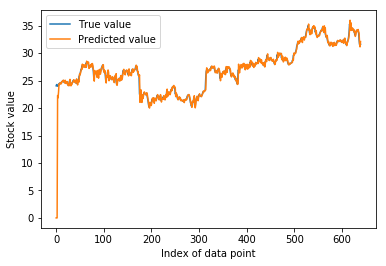

In [112]:
plot_accuracy_graphs(pred_val, actual_val, 'ARMAOGD_accuracy.png')

[]


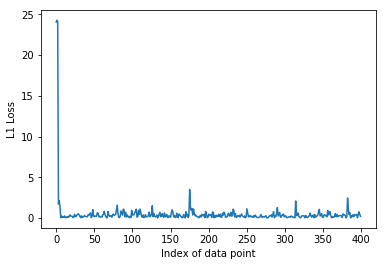

In [113]:
l1_loss_lstm = list()

print(l1_loss_lstm)

for val_iter in range(len(actual_val)):
    l1_loss_lstm.append(L1(pred_val[val_iter], actual_val[val_iter]))

t = 400
plt.plot([x for x in range(400)], l1_loss_lstm[:400])

plt.ylabel('L1 Loss')
plt.xlabel('Index of data point')

plt.savefig('L1_loss_armaogd.png')

plt.show()

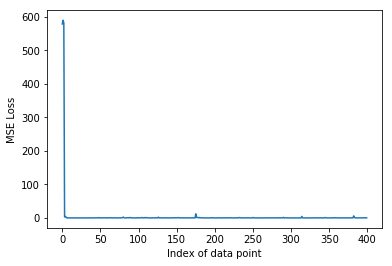

In [114]:
mse_loss_lstm = list()

for val_iter in range(len(actual_val)):
    mse_loss_lstm.append(MSE(pred_val[val_iter], actual_val[val_iter]))

t = 400

plt.plot([x for x in range(400)], mse_loss_lstm[:400])

plt.ylabel('MSE Loss')
plt.xlabel('Index of data point')

plt.savefig('MSE_loss_armaogd.png')


plt.show()

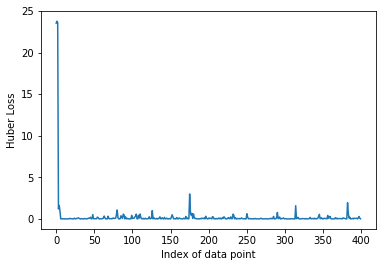

In [115]:
huber_loss_lstm = list()

for val_iter in range(len(actual_val)):
    huber_loss_lstm.append(Huber(pred_val[val_iter], actual_val[val_iter]))

t = 400

plt.plot([x for x in range(400)], huber_loss_lstm[:400])

plt.ylabel('Huber Loss')
plt.xlabel('Index of data point')

plt.savefig('Huber_loss_armaogd.png')


plt.show()

## ARMA ONS

In [119]:
m = 3
k = 2
q = 2

arma_ons = ARMA_ONS(m, k, q)

arma_ons.fit(X=train_data)

(array([  0.        ,   0.10669338,   5.53332172, ...,  24.77952455,
         24.56888847,  23.94434105]),
 array([  1.62486009e+02,   1.55758053e+02,   4.93320566e+01, ...,
          2.27075650e-01,   1.81380987e-01,   7.27159475e-02]))

In [120]:
actual_val = test_data
pred_val = arma_ons.predict(test_data)

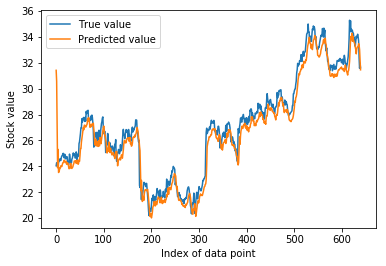

In [121]:
plot_accuracy_graphs(pred_val, actual_val, 'ARMAONS_accuracy.png')

[]


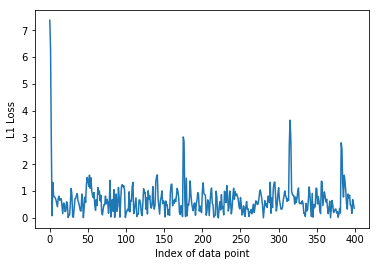

In [122]:
l1_loss_lstm = list()

print(l1_loss_lstm)

for val_iter in range(len(actual_val)):
    l1_loss_lstm.append(L1(pred_val[val_iter], actual_val[val_iter]))

t = 400

plt.plot([x for x in range(400)], l1_loss_lstm[:400])

plt.ylabel('L1 Loss')
plt.xlabel('Index of data point')

plt.savefig('L1_loss_armaons.png')

plt.show()

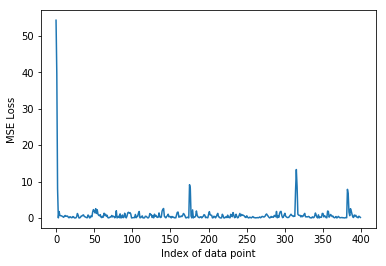

In [123]:
mse_loss_lstm = list()

for val_iter in range(len(actual_val)):
    mse_loss_lstm.append(MSE(pred_val[val_iter], actual_val[val_iter]))

t = 400

plt.plot([x for x in range(400)], mse_loss_lstm[:400])

plt.ylabel('MSE Loss')
plt.xlabel('Index of data point')

plt.savefig('MSE_loss_armaons.png')

plt.show()

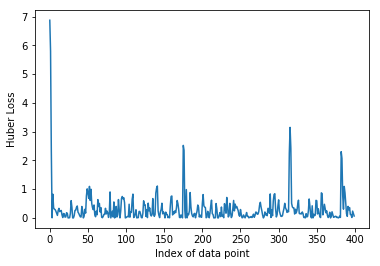

In [124]:
huber_loss_lstm = list()

for val_iter in range(len(actual_val)):
    huber_loss_lstm.append(Huber(pred_val[val_iter], actual_val[val_iter]))

t = 400
plt.plot([x for x in range(400)], huber_loss_lstm[:400])

plt.ylabel('Huber Loss')
plt.xlabel('Index of data point')

plt.savefig('Huber_loss_armaons.png')
plt.show()